In [5]:
# === Imports ===
import os
import icd10
import time
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm import tqdm
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import StandardScaler
from embed_surv_utils import run_grid_CoxPH_parallel, get_heldout_risk_scores_CoxPH

# === Paths ===
FIGURE_PATH = '/data/gusev/USERS/jpconnor/figures/clinical_text_embedding_project/model_metrics/'
DATA_PATH = '/data/gusev/USERS/jpconnor/data/clinical_text_embedding_project/'
SURV_PATH = os.path.join(DATA_PATH, 'time-to-event_analysis/')
RESULTS_PATH = os.path.join(SURV_PATH, 'results/level_3_ICD_results/')
FEATURE_PATH = os.path.join(DATA_PATH, 'clinical_and_genomic_features/')
FULL_COHORT_PATH = os.path.join(RESULTS_PATH, 'full_cohort/')
FEATURE_COMPS_PATH = os.path.join(RESULTS_PATH, 'feature_comps/')
HELD_OUT_PATH = os.path.join(RESULTS_PATH, 'feature_specific_risk/')
os.makedirs(HELD_OUT_PATH, exist_ok=True)

events = list(set(os.listdir(FULL_COHORT_PATH)) & set(os.listdir(FEATURE_COMPS_PATH)))
data_cols = ['DFCI_MRN'] + events + [f'tt_{event}' for event in events]

tte_df = pd.read_csv(os.path.join(SURV_PATH, 'level_3_ICD_embedding_prediction_df.csv'), usecols=data_cols)
event_descr_df = pd.read_csv(os.path.join(RESULTS_PATH, 'ICD_event_descriptions.csv'))

In [6]:
risk_cols = ['text_risk_score', 'stage_risk_score', 'treatment_risk_score', 'prs_risk_score', 'somatic_risk_score']

dfs_to_append = []
cindex_rows = []
failed_events = {}

for event in tqdm(events):
    # --- read ---
    try:
        event_risk_profile = pd.read_csv(os.path.join(HELD_OUT_PATH, f'{event}_held_out_preds.csv'))
    except Exception as e:
        failed_events[event] = f"read error: {e}"
        continue

    try:
        # --- merge + filter ---
        event_pred_df = (
            event_risk_profile
            .merge(tte_df[['DFCI_MRN', event, f'tt_{event}']], on='DFCI_MRN', how='inner')
            .drop(columns=['DFCI_MRN'])
        )
        event_pred_df = event_pred_df.loc[event_pred_df[f'tt_{event}'] > 0].copy()

        # ====== c-index for RAW risk scores (univariate) ======
        # NOTE: lifelines concordance_index expects "higher score => longer survival"
        # If your risk_score means "higher risk => earlier event", use -score.
        T = event_pred_df[f'tt_{event}'].to_numpy()
        E = event_pred_df[event].to_numpy().astype(int)

        for col in risk_cols:
            s = event_pred_df[col].to_numpy()

            ok = np.isfinite(T) & np.isfinite(s) & np.isfinite(E)
            if ok.sum() < 5:
                cidx = np.nan
            else:
                cidx = concordance_index(T[ok], -s[ok], E[ok])  # negate because higher risk => shorter time

            cindex_rows.append({
                "event": event,
                "covariate": col,
                "c_index_raw": cidx,
                "n": int(ok.sum())
            })

        # ====== your existing Cox betas (on standardized cols) ======
        event_pred_df[risk_cols] = StandardScaler().fit_transform(event_pred_df[risk_cols])

        event_model = CoxPHFitter().fit(event_pred_df, duration_col=f'tt_{event}', event_col=event)

        event_model_results = (
            event_model.summary
            .reset_index()[['covariate', 'coef', 'exp(coef)', 'p']]
            .copy())
        
        event_model_results['covariate'] = event_model_results['covariate'].apply(lambda x: x.split('_')[0])
        event_model_results['event'] = event

        dfs_to_append.append(event_model_results)

        ph = event_model.predict_partial_hazard(event_pred_df).to_numpy().ravel()
        ok2 = np.isfinite(T) & np.isfinite(ph) & np.isfinite(E)
        cindex_rows.append({
            "event": event,
            "covariate": "cox_all_5",
            "c_index_raw": concordance_index(T[ok2], -ph[ok2], E[ok2]),
            "n": int(ok2.sum())
        })

    except Exception as e:
        failed_events[event] = f"model fit error: {e}"
        continue

betas_df = pd.concat(dfs_to_append, ignore_index=True) if dfs_to_append else pd.DataFrame()
cindex_df = pd.DataFrame(cindex_rows)

  1%|▏         | 5/338 [00:01<01:35,  3.49it/s]/data/gusev/USERS/jpconnor/conda/envs/clinical_notes_project/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/data/gusev/USERS/jpconnor/conda/envs/clinical_notes_project/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1700: RuntimeWarning: invalid value encountered in add
  risk_phi_x = risk_phi_x + phi_x_i
/data/gusev/USERS/jpconnor/conda/envs/clinical_notes_project/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1701: RuntimeWarning: invalid value encountered in add
  risk_phi_x_x = risk_phi_x_x + phi_x_x_i
/data/gusev/USERS/jpconnor/conda/envs/clinical_notes_project/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/data/gusev/USERS/jpconnor/conda/envs/clinical_notes_project/lib/python3.13/site-packages/li

## Summary Stats

In [7]:
betas_df['sig'] = betas_df['p'] < 0.05

In [8]:
len(betas_df['event'].unique())

243

In [9]:
betas_df.loc[betas_df['sig'], 'covariate'].value_counts()

covariate
text         116
stage         71
treatment     59
prs           54
somatic       44
Name: count, dtype: int64

In [10]:
sig_events = betas_df.loc[betas_df['sig'], 'event'].unique()
len(sig_events)

176

In [11]:
sig_preds_by_event = (betas_df.loc[betas_df['sig']]
                      .groupby('event')['sig'].sum().reset_index()).rename(columns={'sig' : 'num_sig_preds'})
sig_preds_by_event['num_sig_preds'].value_counts()

num_sig_preds
1    80
2    49
4    23
3    23
5     1
Name: count, dtype: int64

In [12]:
sig_preds_by_event.loc[sig_preds_by_event['num_sig_preds'] == 5]

,event,num_sig_preds
143,R41,5


## Performance Plots

In [13]:
cindex_df['covariate'] = cindex_df['covariate'].map({'text_risk_score' : 'text', 'stage_risk_score' : 'stage', 'treatment_risk_score' : 'treatment', 
                                                     'prs_risk_score' : 'prs', 'somatic_risk_score' : 'somatic', 'cox_all_5' : 'CoxPH w/ all features'})

In [14]:
cindex_df_filt = (
    cindex_df
    .assign(
        mu=cindex_df.groupby("covariate")["c_index_raw"].transform("mean"),
        sd=cindex_df.groupby("covariate")["c_index_raw"].transform("std"),
    )
    .loc[lambda d: (d["c_index_raw"] >= d["mu"] - 3*d["sd"]) &
                    (d["c_index_raw"] <= d["mu"] + 3*d["sd"])]
    .drop(columns=["mu", "sd"])
)


In [15]:
order = (cindex_df_filt.groupby('covariate')['c_index_raw'].mean().sort_values(ascending=False).index.tolist())

/tmp/ipykernel_180325/1433175005.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


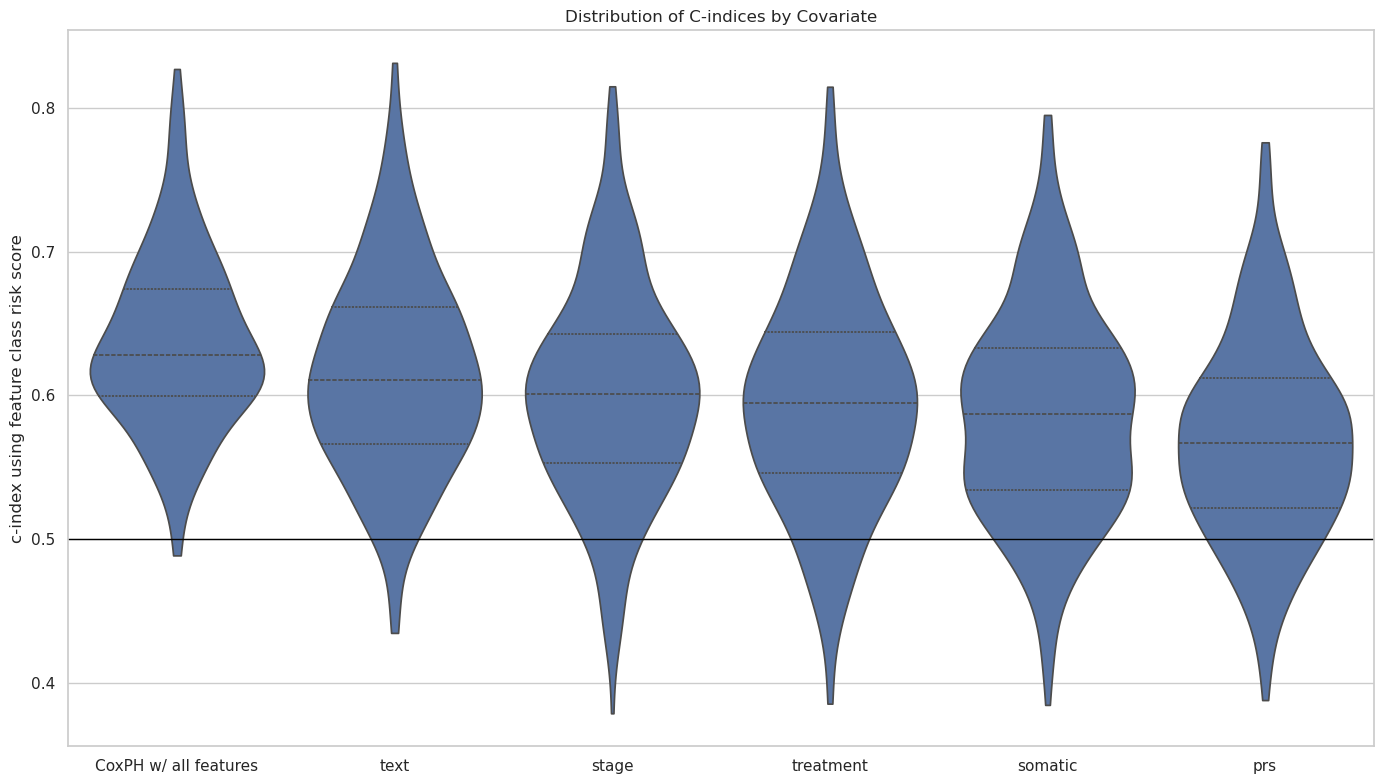

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
ax = sns.violinplot(
    data=cindex_df_filt,
    x="covariate",
    y="c_index_raw",
    order=order,
    inner="quartile",
    cut=0,
    scale="width"
)

ax.set_xlabel("")
ax.set_ylabel("c-index using feature class risk score")
plt.axhline(0.5, color="black", linewidth=1)
# plt.xticks(rotation=45, ha="right")
plt.title("Distribution of C-indices by Covariate")
plt.tight_layout()
plt.show()

In [17]:
cindex_df_w_descr = cindex_df.merge(event_descr_df, on='event')
for covar in cindex_df_w_descr['covariate'].unique():
    cov_cindex_df = cindex_df_w_descr.loc[cindex_df_w_descr['covariate'] == covar].sort_values(by='c_index_raw', ascending=False).iloc[0:5]
    print(covar)
    for index, row in cov_cindex_df.iterrows():
        print(f'Event = {row['event_descr']}')
        # print(f'C-index = {row['c_index_raw'] : 0.3f}')

text
Event = Cytomegaloviral disease
Event = Ovarian dysfunction
Event = Benign prostatic hyperplasia
Event = Immunodeficiency with predominantly antibody defects
Event = Noninflammatory disorders of ovary, fallopian tube and broad ligament
stage
Event = Ovarian dysfunction
Event = Benign prostatic hyperplasia
Event = Noninflammatory disorders of ovary, fallopian tube and broad ligament
Event = Male erectile dysfunction
Event = Inguinal hernia
treatment
Event = Ovarian dysfunction
Event = Benign prostatic hyperplasia
Event = Noninflammatory disorders of ovary, fallopian tube and broad ligament
Event = Male erectile dysfunction
Event = Other chronic obstructive pulmonary disease
prs
Event = Benign prostatic hyperplasia
Event = Inguinal hernia
Event = Hypofunction and other disorders of the pituitary gland
Event = Male erectile dysfunction
Event = Other chronic obstructive pulmonary disease
somatic
Event = Benign prostatic hyperplasia
Event = Inguinal hernia
Event = Other chronic obstruc

In [47]:
pd.set_option("display.max_colwidth", None)

(cindex_df.assign(delta=lambda x: x.c_index_raw - x.groupby("event").c_index_raw.transform("mean"))
    .sort_values("delta", ascending=False)
    .groupby("covariate")
    .head(3)).merge(event_descr_df, on='event')[['event', 'event_descr', 'covariate', 'c_index_raw', 'delta']].sort_values(by=['covariate', 'c_index_raw'], ascending=[True, False]).round(3)

,event,event_descr,covariate,c_index_raw,delta
0,E08,Diabetes mellitus due to underlying condition,CoxPH w/ all features,0.813,0.257
1,G31,"Other degenerative diseases of nervous system, not elsewhere classified",CoxPH w/ all features,0.675,0.230
4,R61,Generalized hyperhidrosis,CoxPH w/ all features,0.671,0.185
6,N50,Other and unspecified disorders of male genital organs,prs,0.752,0.147
7,R65,Symptoms and signs specifically associated with systemic inflammation and infection,prs,0.697,0.126
8,E08,Diabetes mellitus due to underlying condition,prs,0.661,0.105
13,M84,Disorder of continuity of bone,somatic,0.651,0.066
12,H11,Other disorders of conjunctiva,somatic,0.585,0.068
17,D59,Acquired hemolytic anemia,somatic,0.546,0.056
11,E28,Ovarian dysfunction,stage,0.870,0.075


In [62]:
# extreme_events = ['D62', 'H11', 'R26', 'E23', 'D49']
# violin_plot_order = ["stage", "text", "treatment", "prs", "somatic"]

# sig_results_only = betas_df.loc[betas_df['event'].isin(set(sig_events) - set(extreme_events))]

# sig_results_only_filt = (
#     sig_results_only
#     .assign(
#         mu=sig_results_only.groupby("covariate")["coef"].transform("mean"),
#         sd=sig_results_only.groupby("covariate")["coef"].transform("std"),
#     )
#     .loc[lambda d: (d["coef"] >= d["mu"] - 3*d["sd"]) &
#                     (d["coef"] <= d["mu"] + 3*d["sd"])]
#     .drop(columns=["mu", "sd"])
# )
# order = (sig_results_only_filt.groupby('covariate')['coef'].mean().sort_values(ascending=False).index.tolist())

# sns.set(style="whitegrid")

# plt.figure(figsize=(14, 8))
# ax = sns.violinplot(
#     data=sig_results_only_filt,
#     order=order,
#     x="covariate",
#     y="coef",
#     inner="quartile",
#     cut=0,
#     scale="width"
# )

# ax.set_xlabel("")
# ax.set_ylabel("log HRs")

# plt.axhline(0, color="black", linewidth=1)
# plt.title("Distribution of Log HRs by Covariate (Significant events, all features)")
# plt.tight_layout()
# plt.show()

In [61]:
# extreme_events = ['D62', 'H11', 'R26', 'E23', 'D49']

# sig_features_only = betas_df.loc[betas_df['sig']]

# sns.set(style="whitegrid")

# plt.figure(figsize=(14, 8))
# ax = sns.violinplot(
#     data=sig_features_only,
#     order=violin_plot_order,
#     x="covariate",
#     y="coef",
#     inner="quartile",
#     cut=0,
#     scale="width"
# )

# ax.set_xlabel("")
# ax.set_ylabel("log HRs")

# plt.axhline(0, color="black", linewidth=1)
# plt.title("Distribution of Log HRs by Covariate (Significant event, feature combinations only)")
# plt.tight_layout()
# plt.show()

In [70]:
events_to_include = cindex_df.groupby('event')['c_index_raw'].mean().reset_index().sort_values(by='c_index_raw', ascending=False).iloc[0:50]['event'].tolist()

In [95]:
events_to_include = sig_results_only_filt.merge(cindex_df, on='event').groupby('event')['c_index_raw'].mean().reset_index().sort_values(by='c_index_raw', ascending=False).iloc[0:50]['event'].tolist()

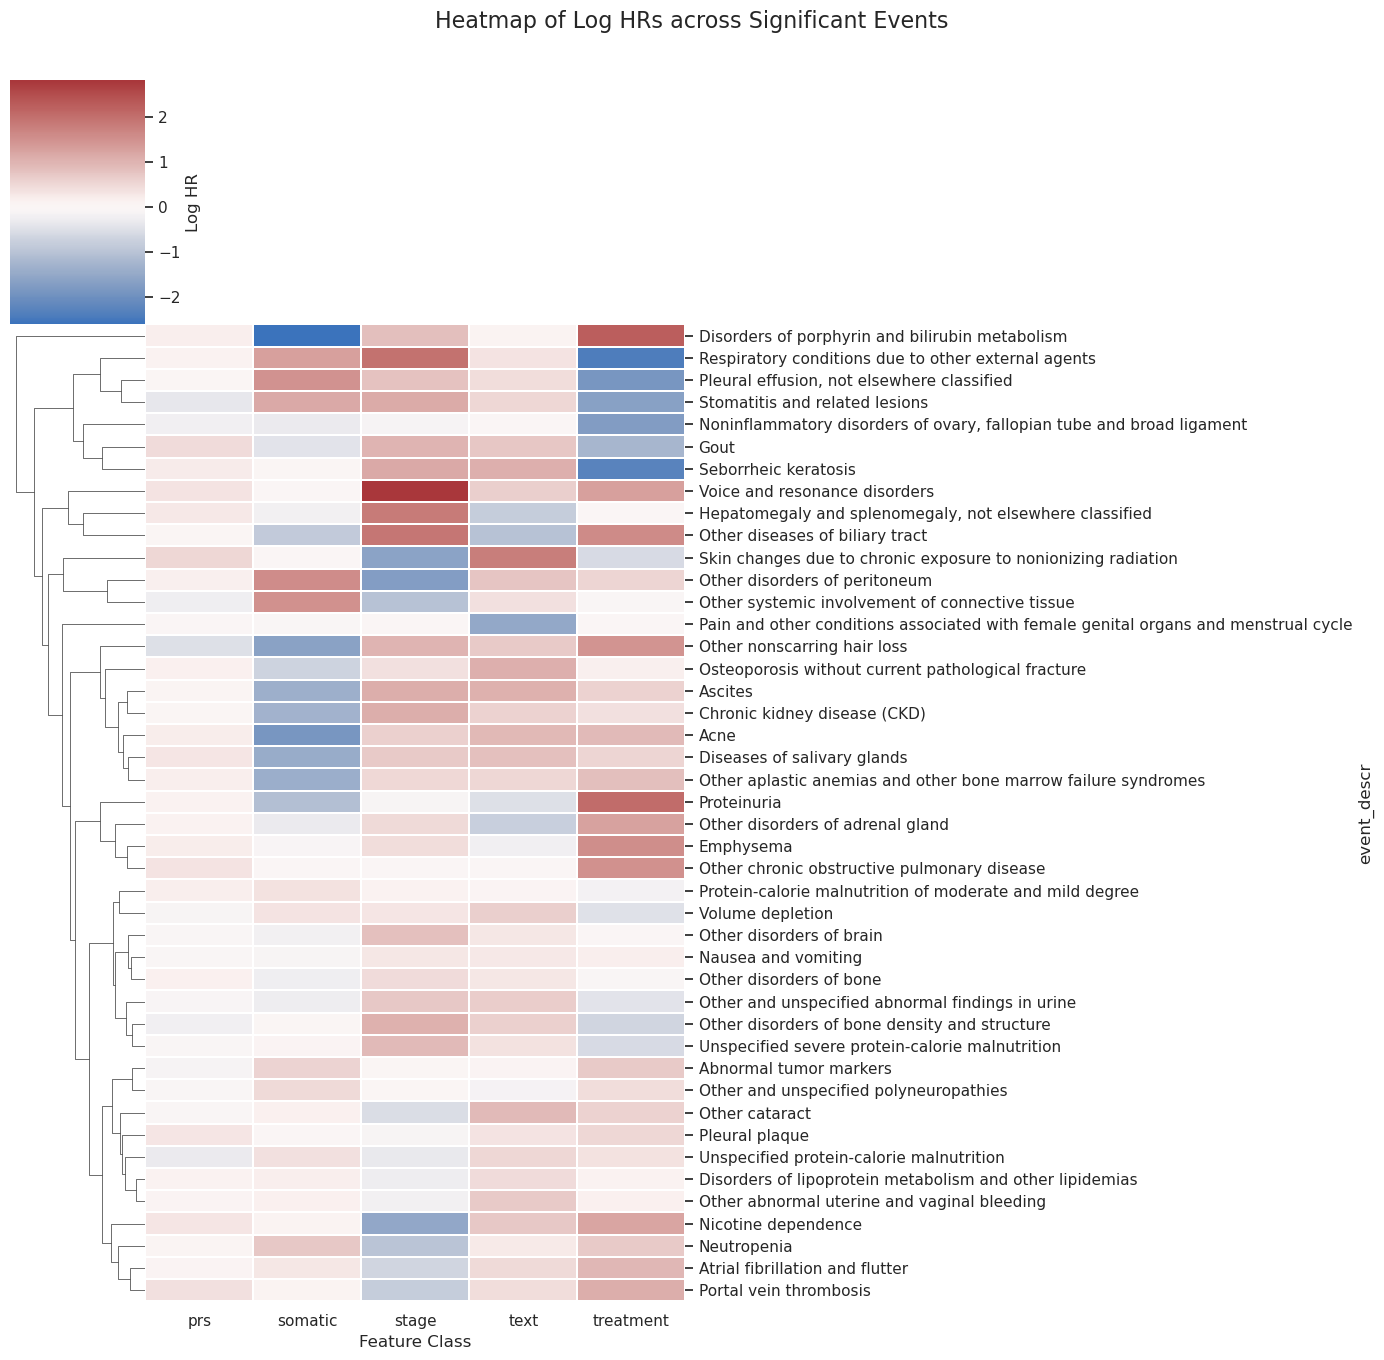

In [96]:
sig_results_only_filt_w_descr = sig_results_only_filt.loc[sig_results_only_filt['event'].isin(events_to_include)].merge(event_descr_df[['event', 'event_descr']], on='event')

heatmap_df = (
    sig_results_only_filt_w_descr
    .pivot_table(
        index="event_descr",
        columns="covariate",
        values="coef",
        aggfunc="mean"   # or first / median if appropriate
    )
    .fillna(0.0)
)

sns.set(context="notebook", style="white")

g = sns.clustermap(
    heatmap_df,
    cmap="vlag",
    center=0,
    method="average",
    metric="euclidean",
    row_cluster=True,
    col_cluster=False,
    figsize=(14, 14),
    linewidths=0.25,
    cbar_kws={"label": "Log HR"},
    cbar_pos=(0.92, 0.15, 0.02, 0.55) 
)

# ---- Remove x-axis labels & ticks ----
# g.ax_heatmap.set_yticks([])
# g.ax_heatmap.set_ylabel("")

# Optional: also remove the column dendrogram axis (since col_cluster=False)
if g.ax_col_dendrogram is not None:
    g.ax_col_dendrogram.set_visible(False)

# Optional: clean y-axis label
g.ax_heatmap.set_xlabel("Feature Class")
# Title + spacing
g.fig.suptitle(
    "Heatmap of Log HRs across Significant Events",
    x=0.5, y=0.97, ha="center", fontsize=16
)
g.fig.subplots_adjust(top=0.92)

# --- HARD align colorbar to heatmap bounds ---
# hm_pos = g.ax_heatmap.get_position()  # Bbox in figure coords

# pad = 0.01          # gap between heatmap and colorbar
# cbar_w = 0.02       # colorbar width

# # Place cbar just to the right of the heatmap, matching heatmap height
# g.cax.set_position([hm_pos.x1 + pad, hm_pos.y0, cbar_w, hm_pos.height])

# # Put ticks/label on the right side of the colorbar
# g.cax.yaxis.set_ticks_position("right")
# g.cax.yaxis.set_label_position("right")

# Pull plot up toward the title
# g.fig.subplots_adjust(top=0.92)
plt.show()

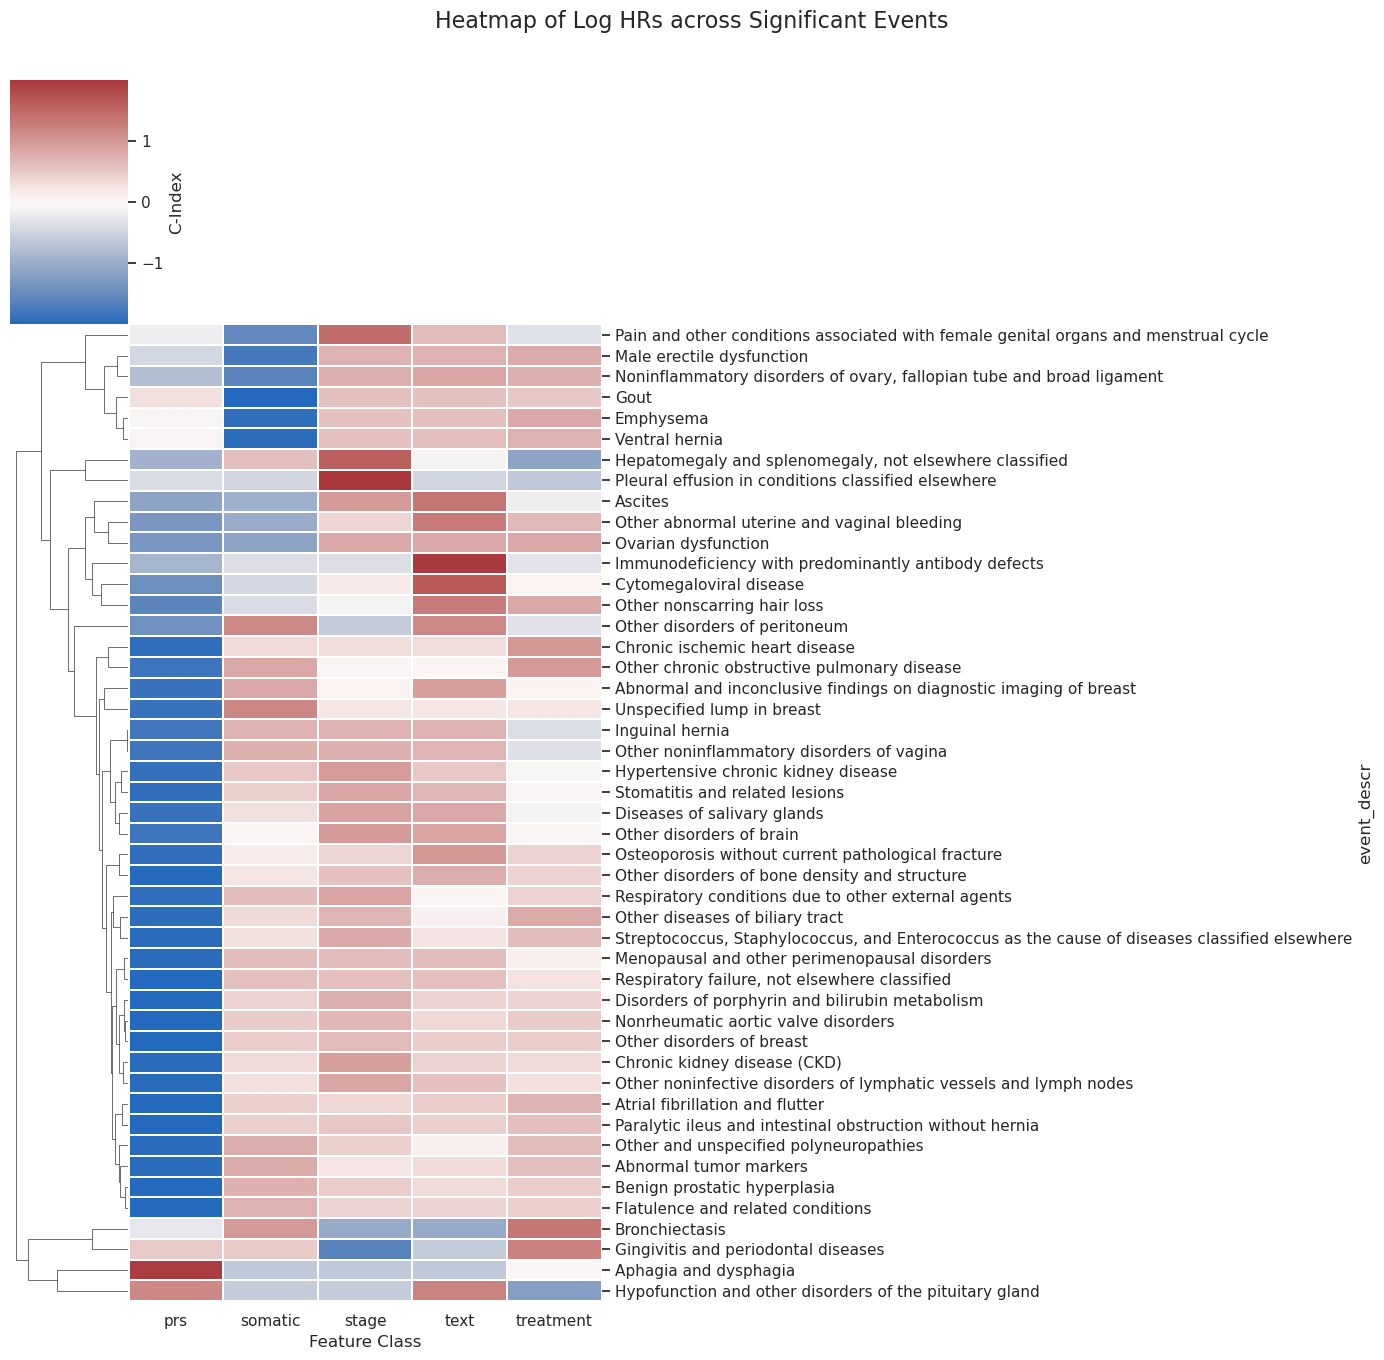

In [97]:
events_to_include = cindex_df.groupby('event')['c_index_raw'].mean().reset_index().sort_values(by='c_index_raw', ascending=False).iloc[0:50]['event'].tolist()
cindex_df_w_descr = cindex_df.loc[(cindex_df['event'].isin(events_to_include)) &
                                  (cindex_df['covariate'] != 'CoxPH w/ all features')].merge(event_descr_df[['event', 'event_descr']], on='event').dropna()

heatmap_df = (
    cindex_df_w_descr
    .pivot_table(
        index="event_descr",
        columns="covariate",
        values="c_index_raw",
        aggfunc="mean"   # or first / median if appropriate
    )
    .fillna(0.0)
)

# --- scale columns (z-score) ---
heatmap_scaled = heatmap_df.apply(
    lambda s: (s - s.mean()) / s.std(ddof=0),
    axis=1
).fillna(0.0)  # handles columns with 0 variance -> NaN


sns.set(context="notebook", style="white")

g = sns.clustermap(
    heatmap_scaled,
    cmap="vlag",
    center=0,
    method="average",
    metric="euclidean",
    row_cluster=True,
    col_cluster=False,
    figsize=(14, 14),
    linewidths=0.25,
    cbar_kws={"label": "C-Index"},
    cbar_pos=(0.92, 0.15, 0.02, 0.55) 
)

# ---- Remove x-axis labels & ticks ----
# g.ax_heatmap.set_yticks([])
# g.ax_heatmap.set_ylabel("")

# Optional: also remove the column dendrogram axis (since col_cluster=False)
if g.ax_col_dendrogram is not None:
    g.ax_col_dendrogram.set_visible(False)

# Optional: clean y-axis label
g.ax_heatmap.set_xlabel("Feature Class")
# Title + spacing
g.fig.suptitle(
    "Heatmap of Log HRs across Significant Events",
    x=0.5, y=0.97, ha="center", fontsize=16
)
g.fig.subplots_adjust(top=0.92)

# --- HARD align colorbar to heatmap bounds ---
# hm_pos = g.ax_heatmap.get_position()  # Bbox in figure coords

# pad = 0.01          # gap between heatmap and colorbar
# cbar_w = 0.02       # colorbar width

# # Place cbar just to the right of the heatmap, matching heatmap height
# g.cax.set_position([hm_pos.x1 + pad, hm_pos.y0, cbar_w, hm_pos.height])

# # Put ticks/label on the right side of the colorbar
# g.cax.yaxis.set_ticks_position("right")
# g.cax.yaxis.set_label_position("right")

# Pull plot up toward the title
# g.fig.subplots_adjust(top=0.92)
plt.show()

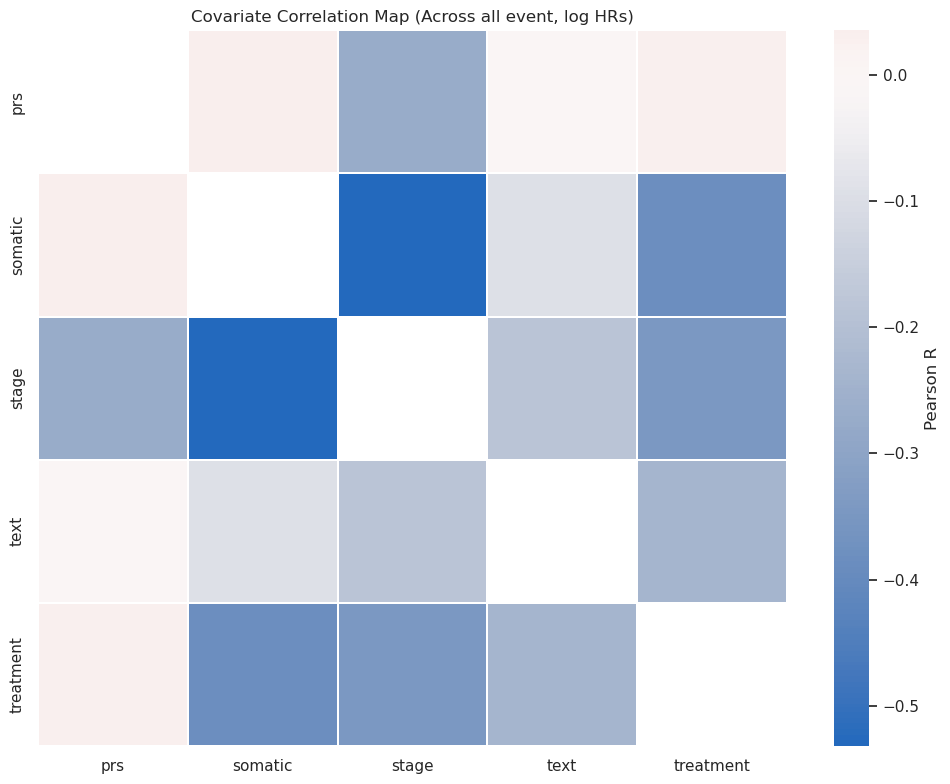

In [168]:
covariate_cols = ["prs", "somatic", "stage", "text", "treatment"]

X = heatmap_df[covariate_cols]

corr = X.corr(method="pearson")  # or "spearman"
mask = np.eye(corr.shape[0], dtype=bool)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap="vlag",
    center=0,
    linewidths=0.25,
    cbar_kws={"label": "Pearson R"}
)

ax.set_xlabel("")
ax.set_ylabel("")

plt.title("Covariate Correlation Map (Across all event, log HRs)")
plt.tight_layout()
plt.show()

## Comparing when both covariates are significant

In [169]:
sig_cov_only = sig_results_only.loc[sig_results_only['p'] < 0.05]

beta_sig_wide = (
    sig_cov_only
    .pivot(index="event", columns="covariate", values="coef")
)

In [170]:
covariates = beta_sig_wide.columns.tolist()

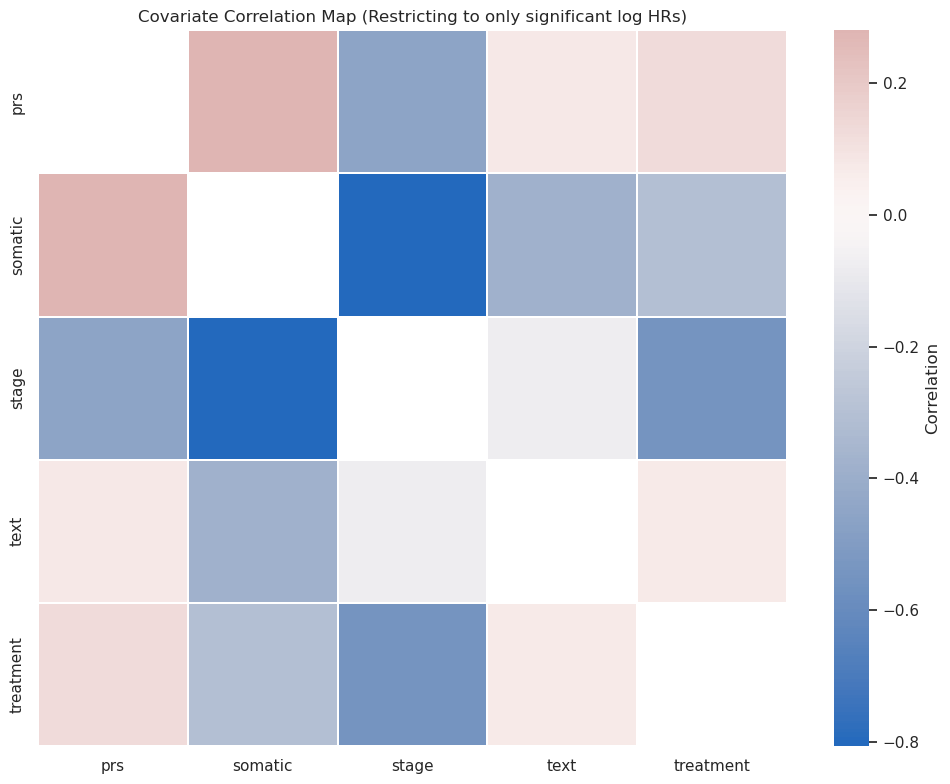

In [172]:
corr_sig_only = beta_sig_wide.corr(method="pearson")
mask = np.eye(corr.shape[0], dtype=bool)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr_sig_only,
    mask=mask,
    cmap="vlag",
    center=0,
    linewidths=0.25,
    cbar_kws={"label": "Correlation"}
)

ax.set_xlabel("")
ax.set_ylabel("")

plt.title("Covariate Correlation Map (Restricting to only significant log HRs)")
plt.tight_layout()
plt.show()
